# Example-55: Demo

In [1]:
# In this DEMO basic functionality used for linear lattice analysis is demonstrated

In [2]:
# Set data type and device

import torch

dtype = torch.float64
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

In [3]:
# Use selected data type and device for all elements

from model.library.element import Element

Element.dtype = dtype
Element.device = device

In [4]:
# Load ELEGANT SDDS twiss or other table

from pathlib import Path
from model.command.external import load_sdds

path = Path('ic.twiss')

# parameters -- {parameter: value}
# columns    -- {element: {parameter: value}}

parameters, columns = load_sdds(path)

In [5]:
# Set tunes, twiss parameters, phase advances and dispersion at BPMs

from model.command.util import select

NUX = torch.tensor(parameters['nux'] % 1, dtype=torch.float64)
NUY = torch.tensor(parameters['nuy'] % 1, dtype=torch.float64)

kinds = select(columns, 'ElementType')

S = torch.tensor([value for value, kind in zip(select(columns, 's').values(), kinds.values()) if kind == 'MONI'], dtype=dtype, device=device)

AX = torch.tensor([value for value, kind in zip(select(columns, 'alphax').values(), kinds.values()) if kind == 'MONI'], dtype=dtype, device=device)
BX = torch.tensor([value for value, kind in zip(select(columns, 'betax' ).values(), kinds.values()) if kind == 'MONI'], dtype=dtype, device=device)
AY = torch.tensor([value for value, kind in zip(select(columns, 'alphay').values(), kinds.values()) if kind == 'MONI'], dtype=dtype, device=device)
BY = torch.tensor([value for value, kind in zip(select(columns, 'betay' ).values(), kinds.values()) if kind == 'MONI'], dtype=dtype, device=device)

MUX = torch.tensor([value for value, kind in zip(select(columns, 'psix').values(), kinds.values()) if kind == 'MONI'], dtype=dtype, device=device)
MUY = torch.tensor([value for value, kind in zip(select(columns, 'psiy').values(), kinds.values()) if kind == 'MONI'], dtype=dtype, device=device)

DQX = torch.tensor([value for value, kind in zip(select(columns, 'etax' ).values(), kinds.values()) if kind == 'MONI'], dtype=dtype, device=device)
DPX = torch.tensor([value for value, kind in zip(select(columns, 'etaxp').values(), kinds.values()) if kind == 'MONI'], dtype=dtype, device=device)
DQY = torch.tensor([value for value, kind in zip(select(columns, 'etay' ).values(), kinds.values()) if kind == 'MONI'], dtype=dtype, device=device)
DPY = torch.tensor([value for value, kind in zip(select(columns, 'etayp').values(), kinds.values()) if kind == 'MONI'], dtype=dtype, device=device)

In [6]:
# Load and build ELEGANT lattice

from model.command.external import load_lattice

path = Path('ic.lte')
data = load_lattice(path)

from model.library.line import Line
from model.command.build import build

ring:Line = build('RING', 'ELEGANT', data)

# Flatten lattice

ring.flatten()

# Merge adjacent drifts (all drifts are renamed)

ring.merge()

# Set linear flag in dipoles (dipoles are nonlinear by default)

for element in ring: 
    if element.kind == 'Dipole':
        element.linear = True

# Set number of elements of different kinds

nb = ring.describe['BPM']
nd = ring.describe['Dipole']
nq = ring.describe['Quadrupole']
ns = ring.describe['Sextupole']

# Describe

print(ring.describe)

{'BPM': 16, 'Drift': 68, 'Quadrupole': 28, 'Dipole': 8, 'Sextupole': 16}


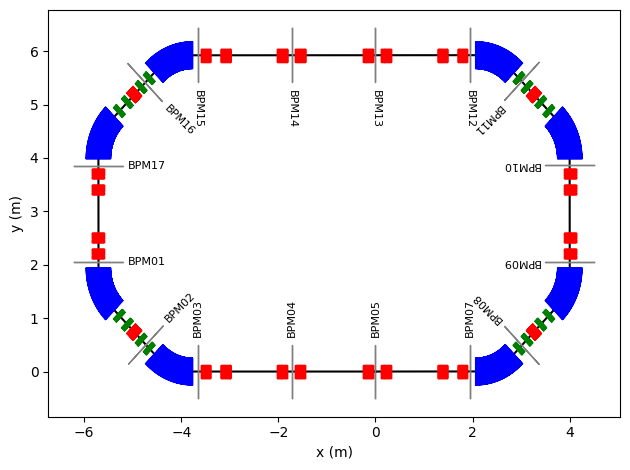

In [7]:
# Plot 2D layout

from model.command.layout import Layout

line = ring.clone()
line.ns = 0.01
layout = Layout(line)

# Generate reference orbit

x, y, _ = layout.orbit(flat=False, step=0.01, start=(0, 0))

# Generate layout

blocks, _ = layout.profile_2d(start=(0, 0), delta=1.0, linewidth=1.0, exclude=['Drift'])
_, labels = layout.profile_2d(start=(0, 0), delta=1.0, linewidth=1.0, exclude=['Dipole', 'Quadrupole', 'Sextupole', 'Drift'], fontsize=8)

# Plot

from matplotlib import pyplot as plt

plt.figure()
plt.plot(x, y, color='black')
for block in blocks:
    plt.errorbar(**block)
for label in labels:
    plt.text(**label)    
plt.xlabel(r'x (m)')
plt.ylabel(r'y (m)')
plt.tight_layout()
plt.show()

In [8]:
# Tracking (single initial)

x = torch.tensor([0.001, 0.0, 0.0, 0.0], dtype=dtype, device=device)

print(ring(x))

tensor([-0.0045,  0.0091,  0.0000,  0.0000], dtype=torch.float64)


In [9]:
# Tracking (vectorized map over initial values)

xs = torch.tensor(2**10*[4*[0.0]], dtype=dtype, device=device)

print(torch.vmap(ring)(xs).shape)

torch.Size([1024, 4])


In [10]:
# Tracking (pass deviation parameters)

data = ring.data()
data['Q3D3']['kn'] = 0.25

print(ring(x, data=data))

tensor([-0.0044,  0.0089,  0.0000,  0.0000], dtype=torch.float64)


In [11]:
# Tracking (wrapper)

from model.command.wrapper import group

kn = torch.tensor([0.25], dtype=dtype, device=device)
mapping, *_ = group(ring, 0, len(ring) - 1, ('kn', None, ['Q3D3'], None))

print(mapping(x, kn))

tensor([-0.0044,  0.0089,  0.0000,  0.0000], dtype=torch.float64)


In [12]:
# Differentiability with respect to initial state

print(torch.func.jacrev(mapping, 0)(x, kn))
print(torch.func.jacrev(mapping, 1)(x, kn))

tensor([[-4.4739, -2.6532,  0.0000,  0.0000],
        [ 8.9295,  5.0721,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  3.8653, -2.1508],
        [ 0.0000,  0.0000,  5.5530, -2.8312]], dtype=torch.float64)
tensor([[ 0.0004],
        [-0.0007],
        [ 0.0000],
        [ 0.0000]], dtype=torch.float64)


In [13]:
# Differentiability with respect to deviation parameters

print(torch.func.jacrev(mapping, 1)(x, kn))

tensor([[ 0.0004],
        [-0.0007],
        [ 0.0000],
        [ 0.0000]], dtype=torch.float64)


In [14]:
# Tunes

from model.command.tune import tune

nux, nuy = tune(ring, [], matched=True)

print(torch.allclose(NUX, nux, rtol=1.0E-12, atol=1.0E-12))
print(torch.allclose(NUY, nuy, rtol=1.0E-12, atol=1.0E-12))

True
True


In [15]:
# Parametric tunes

def fn(dp, kn, ks):
    return tune(ring, [dp, kn, ks], ('dp', None, None, None), ('kn', ['Quadrupole'], None, None),  ('ks', ['Quadrupole'], None, None), matched=True)

# Vectorizing map

dp = torch.tensor([0.0], dtype=dtype, device=device)

kn = torch.zeros(nq, dtype=dtype, device=device)
ks = torch.zeros(nq, dtype=dtype, device=device)

print(torch.vmap(fn, in_dims=(None, 0, None))(dp, torch.stack(2**10*[kn]), ks).shape)

# Derivatives

print(torch.func.jacrev(fn, 0)(dp, kn, ks))
print(torch.func.jacrev(fn, 1)(dp, kn, ks))

torch.Size([1024, 2])
tensor([[0.0284],
        [0.7658]], dtype=torch.float64)
tensor([[ 0.0187,  0.0217,  0.0461,  0.0601,  0.0484,  0.0297,  0.0299,  0.0488,
          0.0597,  0.0457,  0.0214,  0.0192,  0.0669,  0.0667,  0.0191,  0.0216,
          0.0461,  0.0597,  0.0483,  0.0296,  0.0297,  0.0485,  0.0595,  0.0459,
          0.0209,  0.0196,  0.0683,  0.0647],
        [-0.0668, -0.0283, -0.0136, -0.0078, -0.0141, -0.0205, -0.0202, -0.0137,
         -0.0079, -0.0137, -0.0282, -0.0661, -0.0250, -0.0251, -0.0663, -0.0282,
         -0.0137, -0.0079, -0.0138, -0.0203, -0.0205, -0.0140, -0.0078, -0.0137,
         -0.0288, -0.0659, -0.0250, -0.0258]], dtype=torch.float64)


In [16]:
# Twiss parameters

from model.command.twiss import twiss

ax, bx, ay, by = twiss(ring, [], alignment=False, matched=True, advance=True, full=False).T

In [17]:
# Compare Twiss parameters at BPMs

ax_bpm, bx_bpm, ay_bpm, by_bpm = torch.stack([torch.stack([*cs]) for (_, kind, *_), *cs in zip(ring.layout(), ax, bx, ay, by) if kind == 'BPM']).T

print(torch.allclose(AX, ax_bpm, rtol=1.0E-12, atol=1.0E-12))
print(torch.allclose(BX, bx_bpm, rtol=1.0E-12, atol=1.0E-12))
print(torch.allclose(AY, ay_bpm, rtol=1.0E-12, atol=1.0E-12))
print(torch.allclose(BY, by_bpm, rtol=1.0E-12, atol=1.0E-12))

True
True
True
True


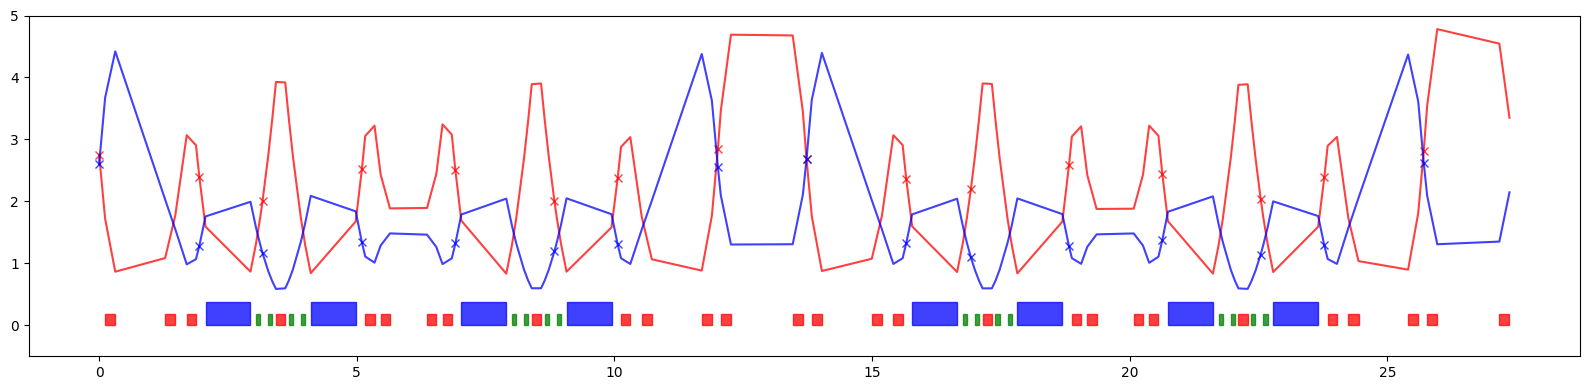

In [18]:
# Plot beta functions

from matplotlib.patches import Rectangle

layout = Layout(ring)
_, _, lengths, *_ = layout.slicing_table()
rectangles = layout.profile_1d(scale=0.75, shift=0.0, text=False,  exclude=['BPM', 'Drift'])

plt.figure(figsize=(16, 4))
plt.errorbar(S.cpu().numpy(), BX.cpu().numpy(), fmt=' ', color='red', alpha=0.75, marker='x')
plt.errorbar(ring.locations().cpu().numpy(), bx.cpu().numpy(), fmt='-', color='red', alpha=0.75)
plt.errorbar(S.cpu().numpy(), BY.cpu().numpy(), fmt=' ', color='blue', alpha=0.75, marker='x')
plt.errorbar(ring.locations().cpu().numpy(), by.cpu().numpy(), fmt='-', color='blue', alpha=0.75)
for rectangle in rectangles:
    plt.gca().add_patch(Rectangle(**rectangle))
plt.ylim(-0.5, 5.0)
plt.tight_layout()
plt.show()

In [19]:
# Parametric twiss (lattice start location)

def fn(dp, kn, ks):
    return twiss(ring, [dp, kn, ks], ('dp', None, None, None), ('kn', ['Quadrupole'], None, None),  ('ks', ['Quadrupole'], None, None), advance=False, matched=True)

# Vectorizing map

dp = torch.tensor([0.0], dtype=dtype, device=device)

kn = torch.zeros(nq, dtype=dtype, device=device)
ks = torch.zeros(nq, dtype=dtype, device=device)

print(torch.vmap(fn, in_dims=(None, 0, None))(dp, torch.stack(2**10*[kn]), ks).shape)

# Derivatives

print(torch.func.jacrev(fn, 0)(dp, kn, ks))
print(torch.func.jacrev(fn, 1)(dp, kn, ks))

torch.Size([1024, 4])
tensor([[-222.0538],
        [-110.7909],
        [  27.9708],
        [ -13.9537]], dtype=torch.float64)
tensor([[-0.0893,  0.4014,  1.2554, -0.9068, -1.5491, -0.9866, -0.6147, -0.7071,
         -1.9186,  0.2045, -0.1659,  0.4221,  1.9239,  2.2147,  0.5854, -0.4487,
         -0.4684, -1.9595, -0.0112, -0.2204, -0.9209, -1.5967, -0.0541,  1.5081,
          0.5988, -0.3222, -0.4638,  0.8415],
        [ 0.0182,  0.1496,  0.5733, -0.6730, -0.7756, -0.5178, -0.4104, -0.5325,
         -0.9651,  0.2699, -0.0145,  0.1734,  0.9035,  1.1954,  0.3374, -0.2984,
         -0.4055, -1.0062,  0.1660, -0.0147, -0.4518, -0.8235,  0.1829,  0.8281,
          0.3562, -0.2319, -0.4848,  0.2358],
        [ 1.6183, -0.0219, -0.2993, -0.0049,  0.3526,  0.2005, -0.5750, -0.4693,
          0.1832,  0.0065, -0.5948, -2.2667, -0.8472,  0.8119,  2.2819,  0.7206,
          0.0759, -0.2127,  0.4684,  0.6358, -0.0792, -0.2893, -0.0394,  0.3584,
          0.2001, -1.2685, -0.6598,  0.2486],
     

In [20]:
# Phase advance

from model.command.advance import advance

mux, muy =  advance(ring, [], alignment=False, matched=True).T

In [21]:
# Total tunes

print(torch.allclose(mux.sum()/(2*torch.pi), torch.tensor(parameters['nux'], dtype=torch.float64), rtol=1.0E-12, atol=1.0E-12))
print(torch.allclose(muy.sum()/(2*torch.pi), torch.tensor(parameters['nuy'], dtype=torch.float64), rtol=1.0E-12, atol=1.0E-12))

True
True


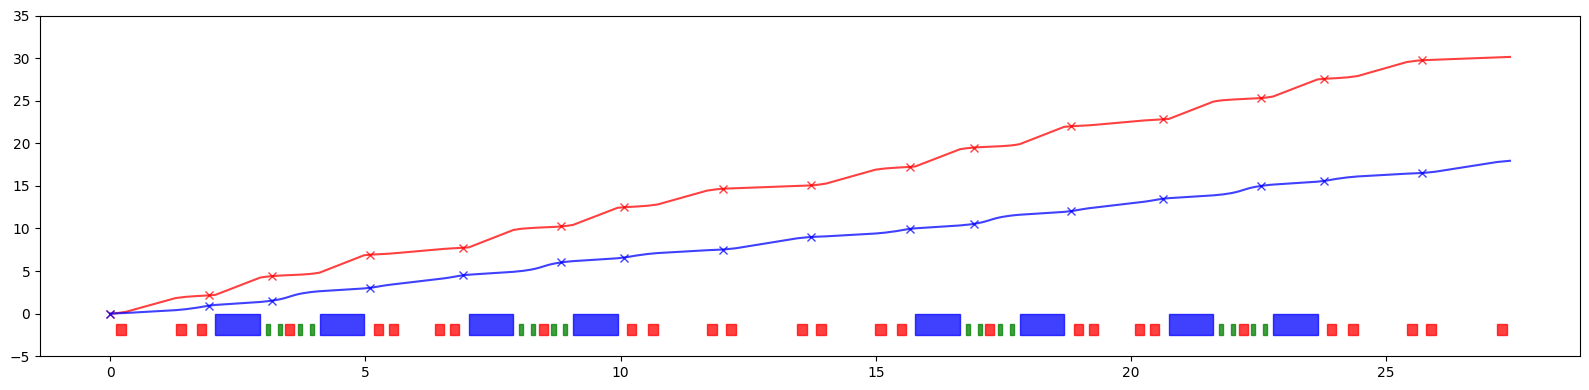

In [22]:
# Plot accumulated phase advance

mux_sum = torch.cat([torch.tensor([0.0], dtype=torch.float64), mux.cumsum(-1)])
muy_sum = torch.cat([torch.tensor([0.0], dtype=torch.float64), muy.cumsum(-1)])

layout = Layout(ring)
_, _, lengths, *_ = layout.slicing_table()
rectangles = layout.profile_1d(scale=5.0, shift=-2.5, text=False,  exclude=['BPM', 'Drift'])

plt.figure(figsize=(16, 4))
plt.errorbar(S.cpu().numpy(), MUX.cpu().numpy(), fmt=' ', color='red', alpha=0.75, marker='x')
plt.errorbar(torch.cat([ring.locations(), ring.length.unsqueeze(-1)]).cpu().numpy(), mux_sum.cpu().numpy(), fmt='-', color='red', alpha=0.75)
plt.errorbar(S.cpu().numpy(), MUY.cpu().numpy(), fmt=' ', color='blue', alpha=0.75, marker='x')
plt.errorbar(torch.cat([ring.locations(), ring.length.unsqueeze(-1)]).cpu().numpy(), muy_sum.cpu().numpy(), fmt='-', color='blue', alpha=0.75)
for rectangle in rectangles:
    plt.gca().add_patch(Rectangle(**rectangle))
plt.ylim(-5.0, 35.0)
plt.tight_layout()
plt.show()

In [23]:
# Parametric advance

def fn(dp, kn, ks):
    return advance(ring, [dp, kn, ks], ('dp', None, None, None), ('kn', ['Quadrupole'], None, None),  ('ks', ['Quadrupole'], None, None), matched=True)

# Vectorizing map

dp = torch.tensor([0.0], dtype=dtype, device=device)

kn = torch.zeros(nq, dtype=dtype, device=device)
ks = torch.zeros(nq, dtype=dtype, device=device)

print(torch.vmap(fn, in_dims=(None, 0, None))(dp, torch.stack(2**10*[kn]), ks).shape)

# Derivatives

print(torch.func.jacrev(fn, 0)(dp, kn, ks).shape)
print(torch.func.jacrev(fn, 1)(dp, kn, ks).shape)

torch.Size([1024, 136, 2])
torch.Size([136, 2, 1])
torch.Size([136, 2, 28])


In [24]:
# Dispersion

from model.command.orbit import dispersion

guess = torch.tensor(4*[0.0], dtype=dtype, device=device)
dqx, dpx, dqy, dpy = dispersion(ring, guess, [], advance=True, full=False)

In [25]:
# Compare dispersion at BPMs

dqx_bpm, dpx_bpm, dqy_bpm, dpy_bpm = torch.stack([torch.stack([*cs]) for (_, kind, *_), *cs in zip(ring.layout(), dqx, dpx, dqy, dpy) if kind == 'BPM']).T

print(torch.allclose(DQX, dqx_bpm, rtol=1.0E-12, atol=1.0E-12))
print(torch.allclose(DPX, dpx_bpm, rtol=1.0E-12, atol=1.0E-12))
print(torch.allclose(DQY, dqy_bpm, rtol=1.0E-12, atol=1.0E-12))
print(torch.allclose(DPY, dpy_bpm, rtol=1.0E-12, atol=1.0E-12))

True
True
True
True


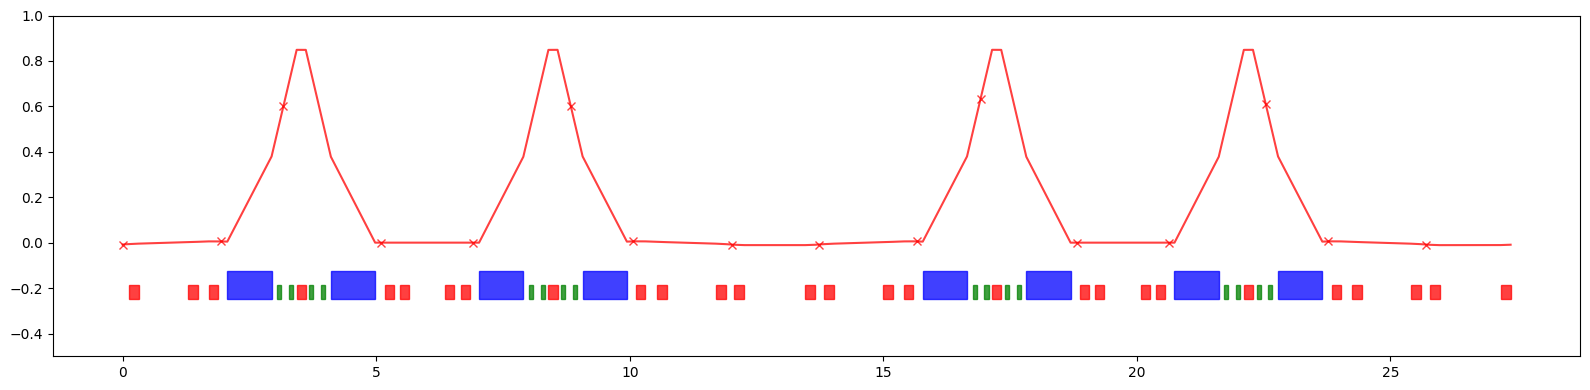

In [26]:
# Plot dispersion

layout = Layout(ring)
_, _, lengths, *_ = layout.slicing_table()
rectangles = layout.profile_1d(scale=0.25, shift=-0.25, text=False,  exclude=['BPM', 'Drift'])

plt.figure(figsize=(16, 4))
plt.errorbar(S.cpu().numpy(), DQX.cpu().numpy(), fmt=' ', color='red', alpha=0.75, marker='x')
plt.errorbar(ring.locations().cpu().numpy(), dqx.cpu().numpy(), fmt='-', color='red', alpha=0.75)
for rectangle in rectangles:
    plt.gca().add_patch(Rectangle(**rectangle))
plt.ylim(-0.5, 1.0)
plt.tight_layout()
plt.show()

In [27]:
# Parametric dispersion

def fn(kn, ks):
    return dispersion(ring, guess, [kn, ks], ('kn', ['Quadrupole'], None, None),  ('ks', ['Quadrupole'], None, None), advance=False)

# Vectorizing map

kn = torch.zeros(nq, dtype=dtype, device=device)
ks = torch.zeros(nq, dtype=dtype, device=device)

print(torch.vmap(fn, in_dims=(0, None))(torch.stack(2**10*[kn]), ks).shape)

# Derivatives

print(torch.func.jacrev(fn, 0)(kn, ks))
print(torch.func.jacrev(fn, 1)(kn, ks))

torch.Size([1024, 4])
tensor([[-1.1162e-03, -8.2786e-04, -2.4801e-03,  1.9629e-01,  2.7563e-05,
          9.5180e-06, -2.3718e-05, -4.7673e-05, -1.0284e-01,  2.2051e-03,
          6.9025e-04,  1.3755e-03,  5.3769e-03,  5.7391e-03,  1.5789e-03,
          3.3797e-04,  1.3670e-03,  8.2397e-02, -6.1463e-05, -3.5245e-05,
         -1.4306e-05, -1.4063e-05,  3.4270e-01, -2.6831e-03, -9.3952e-04,
         -6.7697e-04, -3.2418e-03, -4.2953e-03],
        [ 1.6338e-03,  1.6955e-03,  4.8680e-03, -5.0176e-01, -9.1579e-06,
          8.7653e-06,  6.6251e-05,  1.2097e-04,  2.7302e-02, -3.4149e-03,
         -9.8856e-04, -2.7727e-03, -1.0457e-02, -1.0501e-02, -2.7973e-03,
         -9.4603e-04, -3.3137e-03,  1.1249e-02,  9.2654e-05,  5.0532e-05,
          8.0420e-06, -3.5286e-06, -5.1448e-01,  4.8677e-03,  1.6412e-03,
          1.7617e-03,  7.6393e-03,  9.0321e-03],
        [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
          0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.00

In [28]:
# Modify lattice for ORM computation

from model.library.corrector import Corrector

# Clone lattice

copy = ring.clone()

# Split BPMs and change lattice start

copy.split((None, ['BPM'], None, None))
copy.roll(1)

# Insert correctors into quadrupoles and dipoles

ncq = 2**2
ncd = 2**4

for name in [name for name, kind, *_ in copy.layout() if kind == 'Quadrupole']:
    corrector = Corrector(f'{name}_CXY', factor=1/(ncq - 1))
    copy.split((ncq, None, [name], None), paste=[corrector]) 
    
for name in [name for name, kind, *_ in copy.layout() if kind == 'Dipole']:
    corrector = Corrector(f'{name}_CXY', factor=1/(ncd - 1))
    copy.split((ncd, None, [name], None), paste=[corrector])

# Splice lattice

copy.splice()

# Print sequence between first two BPMs

line, *_ = copy
print(line)

BPM(name="BPM05", direction="inverse", dp=0.0)
Drift(name="DR001", length=0.116715, dp=0.0, exact=False, ns=1, order=0)
Quadrupole(name="Q3D3", length=0.0491425, kn=-8.426928737999999, ks=0.0, dp=0.0, exact=False, ns=1, order=0)
Corrector(name="Q3D3_CXY", cx=0.0, cy=0.0, factor=0.3333333333333333, dp=0.0)
Quadrupole(name="Q3D3", length=0.0491425, kn=-8.426928737999999, ks=0.0, dp=0.0, exact=False, ns=1, order=0)
Corrector(name="Q3D3_CXY", cx=0.0, cy=0.0, factor=0.3333333333333333, dp=0.0)
Quadrupole(name="Q3D3", length=0.0491425, kn=-8.426928737999999, ks=0.0, dp=0.0, exact=False, ns=1, order=0)
Corrector(name="Q3D3_CXY", cx=0.0, cy=0.0, factor=0.3333333333333333, dp=0.0)
Quadrupole(name="Q3D3", length=0.0491425, kn=-8.426928737999999, ks=0.0, dp=0.0, exact=False, ns=1, order=0)
Drift(name="DR002", length=0.9684299999999999, dp=0.0, exact=False, ns=1, order=0)
Quadrupole(name="Q3D2", length=0.0491425, kn=-2.695188250999999, ks=0.0, dp=0.0, exact=False, ns=1, order=0)
Corrector(name="Q3

torch.Size([32, 72])


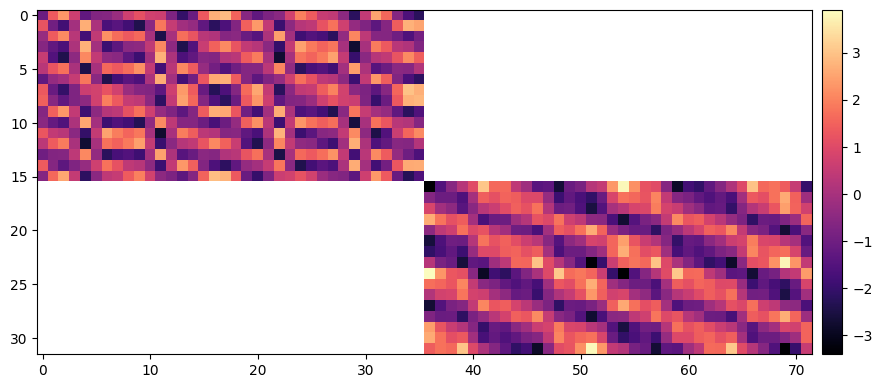

In [29]:
# Compute and plot ORM

from model.command.orbit import ORM

orm = ORM(copy, guess, [])
print(orm.shape)

data = orm.clone()
data[data==0.0] = torch.nan

plt.figure(figsize=(10, 10))
img = plt.imshow(data.cpu().numpy(), cmap='magma', interpolation='nearest')
cax = plt.gcf().add_axes([plt.gca().get_position().x1 + 0.01, plt.gca().get_position().y0, 0.02, plt.gca().get_position().height])
plt.colorbar(img, cax=cax)
plt.show()

In [30]:
# Parametric ORM

def fn(dp, kn, ks):
    return ORM(copy, guess, [dp, kn, ks], ('dp', None, None, None), ('kn', ['Quadrupole'], None, None),  ('ks', ['Quadrupole'], None, None))

dp = torch.tensor([0.0], dtype=dtype, device=device)
kn = torch.zeros(nq, dtype=dtype, device=device)
ks = torch.zeros(nq, dtype=dtype, device=device)

print(torch.func.jacrev(fn, 0)(dp, kn, ks).shape)
print(torch.func.jacrev(fn, 1)(dp, kn, ks).shape)

torch.Size([32, 72, 1])
torch.Size([32, 72, 28])
